Andy Nguyen, Michael Wolfe, Spencer Fogelman, & Joseph Caguioa

DS 7331.407

Thursday 6:30pm - 8:00pm

# Introduction

*Dataset Source: https://www.kaggle.com/rudymizrahi/airbnb-listings-in-major-us-cities-deloitte-ml*

This Kaggle dataset contains data on Airbnb listings for six major U.S. cities. The competition's original goal was to use available attributes to predict listing price. However, the dataset can be adjusted to predict other variables as well.

In this notebook, the dataset will be used for practicing classification techniques on two binned versions of the review_scores_rating variable explored previously.

### Setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import csv
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import warnings

from plotnine import *
%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
def EncodeCategory(col_to_encode):
    distinct_cats = col_to_encode.unique()
    encode_list = []
    i = 1
    for cat in distinct_cats:
        encode_list.append([cat,i])    
        i += 1
    return(encode_list)

***

# Data Preparation Part 1

<i><b>10 pts.</b> Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis.</i>

In [3]:
# Load dataset
df = pd.read_csv('https://raw.githubusercontent.com/anguyen-07/DS7331-ML_Labs/master/data/airbnb_train.csv')

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
df.head()

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,description,first_review,host_has_profile_pic,host_identity_verified,host_response_rate,host_since,instant_bookable,last_review,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds
0,6901257,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,Real Bed,strict,True,NYC,"Beautiful, sunlit brownstone 1-bedroom in the ...",2016-06-18,t,t,NaN,2012-03-26,f,2016-07-18,40.696524,-73.991617,Beautiful brownstone 1-bedroom,Brooklyn Heights,2,100.0,https://a0.muscache.com/im/pictures/6d7cbbf7-c...,11201,1.0,1.0
1,6304928,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,True,NYC,Enjoy travelling during your stay in Manhattan...,2017-08-05,t,f,100%,2017-06-19,t,2017-09-23,40.766115,-73.989040,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6,93.0,https://a0.muscache.com/im/pictures/348a55fe-4...,10019,3.0,3.0
2,7919400,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,Real Bed,moderate,True,NYC,The Oasis comes complete with a full backyard ...,2017-04-30,t,t,100%,2016-10-25,t,2017-09-14,40.808110,-73.943756,The Garden Oasis,Harlem,10,92.0,https://a0.muscache.com/im/pictures/6fae5362-9...,10027,1.0,3.0
3,13418779,6.620073,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,Real Bed,flexible,True,SF,This light-filled home-away-from-home is super...,NaN,t,t,NaN,2015-04-19,f,NaN,37.772004,-122.431619,Beautiful Flat in the Heart of SF!,Lower Haight,0,NaN,https://a0.muscache.com/im/pictures/72208dad-9...,94117.0,2.0,2.0
4,3808709,4.744932,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,Real Bed,moderate,True,DC,"Cool, cozy, and comfortable studio located in ...",2015-05-12,t,t,100%,2015-03-01,t,2017-01-22,38.925627,-77.034596,Great studio in midtown DC,Columbia Heights,4,40.0,NaN,20009,0.0,1.0


In [5]:
df['price'] = np.exp(df['log_price'])
df['grade'] = pd.cut(df.review_scores_rating, [0,60,70,80,90,101], right=False, labels = ['F', 'D', 'C', 'B', 'A'])
df[['grade', 'review_scores_rating']].head()

,grade,review_scores_rating
0,A,100.0
1,A,93.0
2,A,92.0
3,NaN,NaN
4,F,40.0


In [6]:
# Clean up datatypes and duplicates
df_ratings = df.dropna(subset=['review_scores_rating'])
df_ratings.drop_duplicates(inplace=True)
floats = ['log_price','bathrooms','latitude','longitude','review_scores_rating', 'price']
df_ratings[floats] = df_ratings[floats].astype(np.float64)
ints = ['id','accommodates','number_of_reviews','bedrooms','beds']
df_ratings["host_response_rate"] = df_ratings["host_response_rate"].str.rstrip('%').astype(np.float64)/100
date_time = ['first_review','host_since','last_review']
df_ratings[date_time] = df_ratings[date_time].apply(pd.to_datetime)
booleans = ['host_has_profile_pic','host_identity_verified','instant_bookable']
df_ratings[booleans] = df_ratings[booleans].replace({'t':True,'f':False})
df_ratings[booleans] = df_ratings[booleans].astype(np.bool)
categorical = ['property_type','room_type','bed_type','cancellation_policy','city','neighbourhood','zipcode']
df_ratings[categorical] = df_ratings[categorical].astype('category')
df_ratings.drop_duplicates()
df_ratings.host_since[df_ratings.host_since.isna()] = df_ratings.first_review[df_ratings.host_since.isna()]

In [7]:
# Impute missing values
df_imputed = df_ratings
df_imputed["bathrooms"] = df_imputed["bathrooms"].fillna(df_imputed.groupby(["property_type","accommodates"])["bathrooms"].apply(lambda x : x.fillna(x.median())))
df_imputed["bedrooms"] = df_imputed["bedrooms"].fillna(df_imputed.groupby(["property_type","accommodates"])["bedrooms"].apply(lambda x : x.fillna(x.median())))
df_imputed["beds"] = df_imputed["beds"].fillna(df_imputed.groupby(["property_type","accommodates"])["beds"].apply(lambda x : x.fillna(x.median())))
df_imputed["host_response_rate"] = df_imputed["host_response_rate"].fillna(df_imputed.groupby(["number_of_reviews"])["host_response_rate"].apply(lambda x : x.fillna(x.mean())))
# Impute Missing Value of for 100% Host Response Rate for Row 48194 - Private Room in Apartment
df_imputed["host_response_rate"][df_imputed["host_response_rate"].isna()] = 1.0
df_imputed[ints] = df_imputed[ints].astype(np.int64)

In [8]:
import re
#Create a new cleaned amenities column where all amenities are in list form
df_imputed['amenities_new'] = df_imputed.apply(lambda row: re.sub(r'[{}""]', '', row['amenities']), axis=1)
df_imputed['amenities_new'] = df_imputed.apply(lambda row: row['amenities_new'].lower().split(','), axis=1)
df_imputed = df_imputed.reset_index()
df_imputed['length_amenities'] = df_imputed.apply(lambda row: len(row['amenities_new']), axis=1)

# Create separate columns based on amenities
df_imputed['internet'] = df_imputed.apply(lambda row: 'internet' in row.amenities.lower(), axis=1)
df_imputed['TV'] = df_imputed.apply(lambda row: 'tv' in row.amenities.lower(), axis=1)
df_imputed['air_conditioning'] = df_imputed.apply(lambda row: 'air conditioning' in row.amenities.lower(), axis=1)
df_imputed['kitchen'] = df_imputed.apply(lambda row: 'kitchen' in row.amenities.lower(), axis=1)
df_imputed['pool'] = df_imputed.apply(lambda row: 'pool' in row.amenities.lower(), axis=1)
df_imputed['parking'] = df_imputed.apply(lambda row: 'parking' in row.amenities.lower(), axis=1)

# Get information from description based on length in characters
df_imputed['description_length'] = df_imputed['description'].apply(len)

# Create the target variable superuser
df_imputed['superuser'] = False
df_imputed.loc[df.review_scores_rating >=96, 'superuser'] = True

# Create altnerative target variable grade_grouped
new_grades = {
    'A':'A',
    'B':'<A',
    'C':'<A',
    'D':'<A',
    'F':'<A'
}
df_imputed['grade_grouped'] = df_imputed['grade'].map(new_grades)

In [9]:
import datetime
date_published = datetime.datetime(2018,3,14)
df_imputed['host_since'] = pd.to_datetime(df_imputed['host_since'])
df_imputed['host_since_days'] = df_imputed.apply(lambda row: (date_published - row['host_since']).days, axis=1)

Removed columns that are not meaningful in a modeling context (i.e., index,id), redundant with newly engineered features (i.e., amenities, description), or are likenly not useful in predicting the target variable grade_grouped.

In [10]:
# delete useless columns
df_logistic = df_imputed.drop(['index','id','amenities','description','zipcode','description_length',
                               'latitude','longitude','name','neighbourhood','review_scores_rating','thumbnail_url',
                               'zipcode'], axis=1)

# delete other redundant variables
del df_logistic['amenities_new']
del df_logistic['host_since']
# del df_logistic['grade']
del df_logistic['first_review']
del df_logistic['last_review']

# Remove factor with unncessarily large number of levels
df_logistic.drop(['property_type'], axis=1, inplace=True)

One-Hot Encode Categorical Variables with multiple levels.

In [11]:
categorical_vars = ['room_type','bed_type','cancellation_policy','city']

# Create Dummy Variables
multiCategorical_vars = ['city','cancellation_policy','bed_type','room_type']

dummy_df = pd.get_dummies(df_logistic[multiCategorical_vars], drop_first = True)
df_final = pd.concat([df_logistic, dummy_df], axis=1)
del df_final['grade']

# Delete non-dummy categorical variables
for x in categorical_vars:
    if x in df_final:
        del df_final[x]

***

# Data Preparation Part 2

<i><b>5 pts.</b> Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created).</i>

In [12]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57389 entries, 0 to 57388
Data columns (total 37 columns):
log_price                              57389 non-null float64
accommodates                           57389 non-null int64
bathrooms                              57389 non-null float64
cleaning_fee                           57389 non-null bool
host_has_profile_pic                   57389 non-null bool
host_identity_verified                 57389 non-null bool
host_response_rate                     57389 non-null float64
instant_bookable                       57389 non-null bool
number_of_reviews                      57389 non-null int64
bedrooms                               57389 non-null int64
beds                                   57389 non-null int64
price                                  57389 non-null float64
length_amenities                       57389 non-null int64
internet                               57389 non-null bool
TV                                     57389 non

In [13]:
df_final.describe()

,log_price,accommodates,bathrooms,host_response_rate,number_of_reviews,bedrooms,beds,price,length_amenities,host_since_days,city_Chicago,city_DC,city_LA,city_NYC,city_SF,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,room_type_Private room,room_type_Shared room
count,57389.000000,57389.000000,57389.000000,57389.000000,57389.000000,57389.000000,57389.000000,57389.000000,57389.000000,57389.000000,57389.000000,57389.000000,57389.000000,57389.000000,57389.000000,57389.000000,57389.000000,57389.000000,57389.000000,57389.000000,57389.000000,57389.000000,57389.000000,57389.000000,57389.000000
mean,4.749232,3.218247,1.225967,0.952633,26.957326,1.260904,1.737546,147.748297,18.357943,1373.129380,0.055899,0.071442,0.299465,0.436111,0.087944,0.287355,0.484884,0.001446,0.000174,0.002771,0.010560,0.008608,0.972068,0.399536,0.025144
std,0.668700,2.144154,0.561473,0.122000,41.043449,0.841280,1.265311,134.512852,6.907464,662.667741,0.229729,0.257564,0.458028,0.495906,0.283215,0.452532,0.499776,0.038003,0.013199,0.052564,0.102216,0.092380,0.164780,0.489807,0.156564
min,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,167.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.304065,2.000000,1.000000,0.940000,3.000000,1.000000,1.000000,74.000000,14.000000,851.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,4.700480,2.000000,1.000000,1.000000,11.000000,1.000000,1.000000,110.000000,18.000000,1312.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,5.164786,4.000000,1.000000,1.000000,33.000000,1.000000,2.000000,175.000000,22.000000,1841.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,7.600402,16.000000,8.000000,1.000000,605.000000,10.000000,18.000000,1999.000000,77.000000,3663.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


The original variable price was not including in the model. Instead, there was log price, likely made to compress the outliers of price (for example, there was an entire island for rent). We exponentiated log price to get back the original price variable.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c1e785e10>]],
      dtype=object)

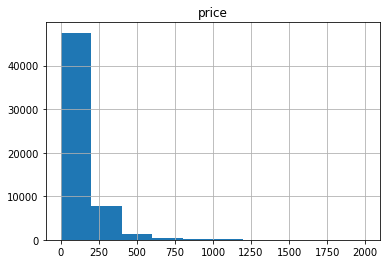

In [14]:
df_final.hist(column='price')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c2bdcdb10>]],
      dtype=object)

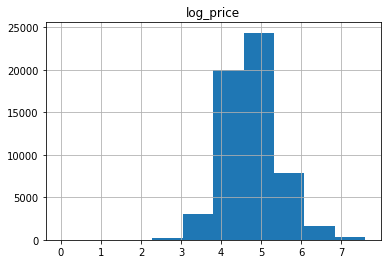

In [15]:
df_final.hist(column='log_price')

As pictured above, the log price has a much more normal distribution. Another attribute we created is the host_since_days, a calculation of how many days a host has been active, defined as the days they became a host subtracted from the date the dataset was made publcally available.

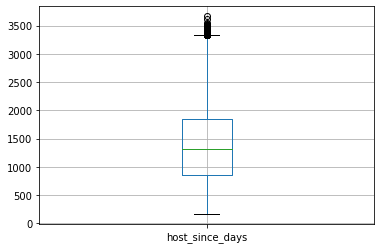

In [16]:
df_final.boxplot(column='host_since_days')

This appears to be right-skewed, with a number of outliers. Some of the hosts look to have been active for a very long time. 

We also created a variable called length_amenities. The original amenities variable was a list of all the reported amenties. We wanted to see if there was a correlation between the length of this list and the overall grade of the property.

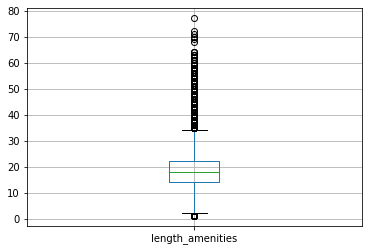

In [17]:
df_final.boxplot(column='length_amenities')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c2db62d10>]],
      dtype=object)

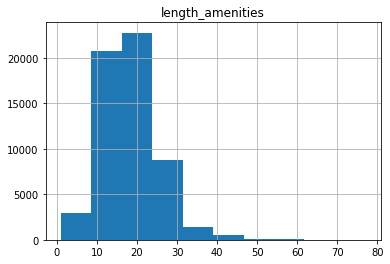

In [18]:
df_final.hist(column='length_amenities')

There is an apparent right skew. There are a number of people who have very long lists of amenities.
**For the purpose of our first classification task**, we have created a grade_grouped target variable to identify potential hosts that may be targeted for AirBnb's superhost program if they have at least 90% for their rating review scores. We grouped all grades under an A as being less than an A because most people in the dataset have an A rating and we wanted to mitigate the class imbalance and create a binary variable to predict.

A     47897
<A     9492
Name: grade_grouped, dtype: int64

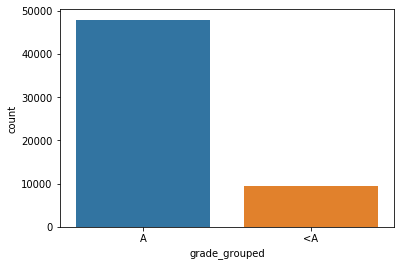

In [19]:
sns.countplot(data=df_final, x = 'grade_grouped')
df_final['grade_grouped'].value_counts()

For the grade_grouped target variable, there is a heavy imbalance of classes with 47,897 (83.5%) instances in the dataset reciving a rating review score of 90% or higher. On the other hand, only 9,492 instances recieved a rating review score lower than 90%. Although our EDA, shows a clear separation between the classes of A and <A compared to the 96% cutoff with the superuser variable. With this heavy imbalance, we will attempt to build our classification models using prior probabilities to optimize model performance and prediction accuracy.

**For the purpose of the second classification task**, we decided to subset our dataset based on all listing records that recieved an A or at least 90% on their review scores rating. From there we will use the superuser target variable to further investigate what separates good AirBnb listings (at least 90%) and exceptional listings (at least 96%, the minimum overall rating from reviews to be eligible for the Superhost program). This task will be performed with the dataset named df_superuser_subset.

In [20]:
df_superuser_subset = df_final.loc[df_imputed['grade'] == 'A'].reset_index()
df_superuser_subset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47897 entries, 0 to 47896
Data columns (total 38 columns):
index                                  47897 non-null int64
log_price                              47897 non-null float64
accommodates                           47897 non-null int64
bathrooms                              47897 non-null float64
cleaning_fee                           47897 non-null bool
host_has_profile_pic                   47897 non-null bool
host_identity_verified                 47897 non-null bool
host_response_rate                     47897 non-null float64
instant_bookable                       47897 non-null bool
number_of_reviews                      47897 non-null int64
bedrooms                               47897 non-null int64
beds                                   47897 non-null int64
price                                  47897 non-null float64
length_amenities                       47897 non-null int64
internet                               47897 no

False    27558
True     20339
Name: superuser, dtype: int64

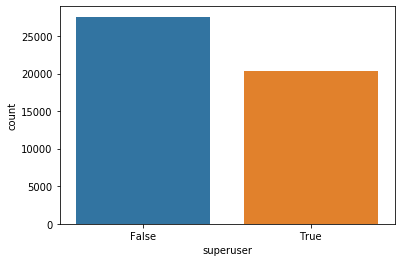

In [21]:
sns.countplot(data=df_superuser_subset, x = 'superuser')
df_superuser_subset['superuser'].value_counts()
#adjust classification penalty against true, class weights, over/under sample

For the superuser target variable in df_superuser_subset, there is a slight imbalance of classes with 27,558 (57.5%) instances in the dataset reciving a rating review score between 90-96%. On the other hand, there are 20,339 instances that recieved a rating review score of 96% and higher.

In [22]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57389 entries, 0 to 57388
Data columns (total 37 columns):
log_price                              57389 non-null float64
accommodates                           57389 non-null int64
bathrooms                              57389 non-null float64
cleaning_fee                           57389 non-null bool
host_has_profile_pic                   57389 non-null bool
host_identity_verified                 57389 non-null bool
host_response_rate                     57389 non-null float64
instant_bookable                       57389 non-null bool
number_of_reviews                      57389 non-null int64
bedrooms                               57389 non-null int64
beds                                   57389 non-null int64
price                                  57389 non-null float64
length_amenities                       57389 non-null int64
internet                               57389 non-null bool
TV                                     57389 non

Finally we wanted to get valuable information from the amenities list and created boolean variables about whether or not a property had internet, TV, air conditioning, parking, or a kitchen.

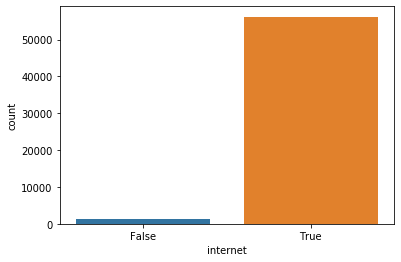

In [23]:
sns.countplot(df_final.internet)

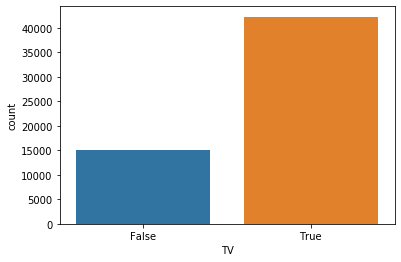

In [24]:
sns.countplot(df_final.TV)

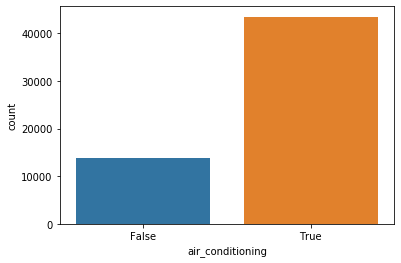

In [25]:
sns.countplot(df_final.air_conditioning)

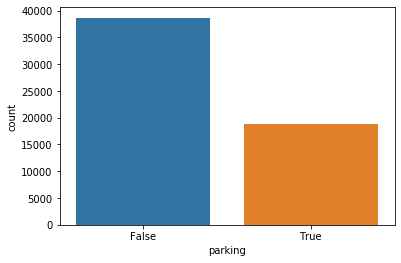

In [26]:
sns.countplot(df_final.parking)

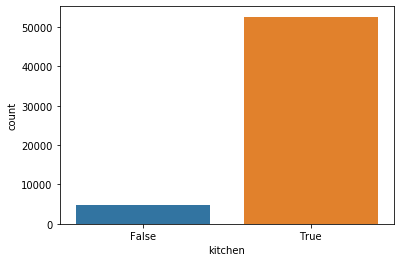

In [27]:
sns.countplot(df_final.kitchen)

***

# Modeling and Evaluation 1

<i><b>10 pts.</b> Choose and explain your evaluation metrics that you will use (i.e., accuracy, precision, recall, F-measure, or any metric we have discussed). Why are the measure(s) appropriate for analyzing the results of your modeling? Give a detailed explanation backing up any assertions.</i>

For our first classification task with the grade_grouped target responsible, we aim to investigate potential AirBnb hosts that should be targeted for the Superhost program. We will prioritize high precision for the grade_grouped target variable since there is a large majority for the class with an A grade for their ratings review score. With an abundance of instances for this class, we would like to minimize the false positives because we want to correctly determine which AirBnb hosts are ideal for the Superhost program. We also may want to evaluate our model with the F-measure to minimize the false negative predictions because we do not want to miss out on superb hosts that would benefit from the Superhost program. We want to penalize the misclassification of listings with an actual grade of less than A to A more than the misclassification of a listing with an actual grade of A to a grade less than A in the classification models for this first task.
    
For our second classification task with the superuser target variable in df_superuser_subset, we will look into overall classification accuracy since the penalty cost for false negatives and false positives are roughly the same since the classes are not heavily imbalanced. We may also want to investigate precision in the models for this task as well since we want to explore how Superhosts (>=96%) are differentiated from good AirBnb hosts (90-95%).

In [28]:
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

***

# Modeling and Evaluation 2

<i><b>10 pts.</b> Choose the method you will use for dividing your data into training and testing splits (i.e., are you using Stratified 10-fold cross validation? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. For example, if you are using time series data then you should be using continuous training and testing sets across time.</i>

The method we will use to divide the data into training and test splits will be stratified 5-fold cross validation due to our large class imbalance in the grade_grouped target response variable; it is an approximately 5:1 ratio on A vs everything B and lower. With stratified 5-fold cross validation, each fold will be approximately representative of the ratio of classes as the full dataset. In other words, each of the 5 splits of the complete dataset will contain roughly the same percentage of each class from our grade_grouped target response variable.

With a stratified K-fold cross validation technique, we avoid high variance issues of a holdout method while benefiting from the bias and variance reduction of K-fold cross validation. The additional stratification of our data splits will address the class imbalance issue in our dataset. We will use this data split technique for both tasks since there is class imbalance present in both datasets, even though the second classification task on the superhost target response variable is only slighltly imbalanced, at an approximate 1.35:1 ratio on False vs True.

##### Keep if we are going to do Stratified Shuffle Split, delete if we are just going to use Stratified Shuffle Split
We will divide the data using a 90% training set and 10% test set since we want our models to be trained on as much data as possible in order to ensure the best possible accuracy. However, we may alter our approach to a 80%/20% training-test split if the model effiency and training times are poor.

### Task 1: grade_grouped target response

In [29]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn import metrics as mt

# Task 1: grade_grouped target response variable
# separate response variable from training data
X1 = df_final.drop(['superuser','grade_grouped'],axis=1)
y1 = df_final['grade_grouped']

yhat1 = np.zeros(y1.shape) # will be filled with the predictions
y1 = y1.replace({'A':True, '<A':False})


# Scale data
scl = StandardScaler()
X1 = scl.fit_transform(X1)

# Create CV iterator
cv = StratifiedKFold(n_splits=5)

# Iterate through CV and get predictions
#for train, test in cv.split(X1,y1):
#    clf.fit(X1[train],y1[train])
#    yhat1[test] = clf.predict(X1[test]) 

### Task 2: superuser target response

In [30]:
# Task 2: superuser target response in df_superuser_subset
# separate response variable from training data
X2 = df_superuser_subset.drop(['superuser','grade_grouped'],axis=1)
y2 = df_superuser_subset['superuser']
yhat2 = np.zeros(y2.shape) # will be filled with the predictions

# Scale data
scl = StandardScaler()
X2 = scl.fit_transform(X2)

# Create CV iterator
cv = StratifiedKFold(n_splits=5)

# Iterate through CV and get predictions
#for train, test in cv.split(X2,y2):
#    clf.fit(X2[train],y2[train])
#    yhat2[test] = clf.predict(X2[test]) 

***

# Modeling and Evaluation 3

<i><b>20 pts.</b> Create three different classification/regression models for each task (e.g., random forest, KNN, and SVM for task one and the same or different algorithms for task two). Two modeling techniques must be new (but the third could be SVM or logistic regression). Adjust parameters as appropriate to increase generalization performance using your chosen metric. You must investigate different parameters of the algorithms!</i>

In [30]:
#RF, KNN regression, logistic regression

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

clf_pipe = Pipeline(
           ["LogisticRegression", LogisticRegression(penalty = "l2", C = 1.0, class_weight = None, solver = 'liblinear', random_state = 0),
            "RandomForest", RandomForestClassifier(n_estimators = 100, max_depth = 2, random_state = 0),
            "KNN", KNeighborClassifier(n_neighbors = 5, weights = "uniform", metric = "euclidean")]
)

### Logistic Regression: grade_grouped (Task 1)

##### Parameter Optimzation

In [123]:
from sklearn.linear_model import LogisticRegression

penalty = ["l1", "l2"]
class_weight = [dict({True:0.835, False:0.165}), "balanced", None]

# Iterate through model parameters to optimize Logistic Regression Model
for i in penalty:
    for j in class_weight:
            LR_clf = LogisticRegression(penalty = i, C = 1.0, class_weight = j, solver = 'liblinear', random_state = 0)
            # Iterate through CV and get predictions
            fold = 0
            for train, test in cv.split(X1,y1):
                fold += 1
                LR_clf.fit(X1[train],y1[train])
                yhat1[test] = LR_clf.predict(X1[test])
                print("The precision for Fold " + str(fold) + " with " + str(i) + ", " + str(j) +
                      " is " + str(precision_score(y1[test], yhat1[test])))
                print("The F-measure for Fold " + str(fold) + " with " + str(i) + ", " + str(j) +
                      " is " + str(f1_score(y1[test], yhat1[test])))

The precision for Fold 1 with l1, {True: 0.835, False: 0.165} is 0.8346401812162397
The F-measure for Fold 1 with l1, {True: 0.835, False: 0.165} is 0.9098679836641657
The precision for Fold 2 with l1, {True: 0.835, False: 0.165} is 0.8345674710340621
The F-measure for Fold 2 with l1, {True: 0.835, False: 0.165} is 0.9098247780046536
The precision for Fold 3 with l1, {True: 0.835, False: 0.165} is 0.8346113628441966
The F-measure for Fold 3 with l1, {True: 0.835, False: 0.165} is 0.909807646639753
The precision for Fold 4 with l1, {True: 0.835, False: 0.165} is 0.8346985012199373
The F-measure for Fold 4 with l1, {True: 0.835, False: 0.165} is 0.9099026359534552
The precision for Fold 5 with l1, {True: 0.835, False: 0.165} is 0.8346113628441966
The F-measure for Fold 5 with l1, {True: 0.835, False: 0.165} is 0.909807646639753
The precision for Fold 1 with l1, balanced is 0.8968860164512339
The F-measure for Fold 1 with l1, balanced is 0.7451793995606543
The precision for Fold 2 with l1

##### Optimized Model

In [81]:
LR_clf1 = LogisticRegression(penalty = "l2", C = 1.0, class_weight = None, solver = 'liblinear', random_state = 0)

# Iterate through CV and get predictions
fold = 0
for train, test in cv.split(X1,y1):
    fold += 1
    LR_clf1.fit(X1[train],y1[train])
    yhat1[test] = LR_clf1.predict(X1[test])
    print("The precision for Fold " + str(fold) + " is " + str(precision_score(y1[test], yhat1[test])))
    print("The F-measure for Fold " + str(fold) + " is " + str(f1_score(y1[test], yhat1[test])))

The precision for Fold 1 is 0.8369765604424546
The F-measure for Fold 1 is 0.9092556387392112
The precision for Fold 2 is 0.8361646234676007
The F-measure for Fold 2 is 0.9094285714285715
The precision for Fold 3 is 0.8362152198718511
The F-measure for Fold 3 is 0.9085447263017357
The precision for Fold 4 is 0.8358731826939919
The F-measure for Fold 4 is 0.9090822498452159
The precision for Fold 5 is 0.8366380066678365
The F-measure for Fold 5 is 0.909186251608905


### Logistic Regression: superhost (Task 2)

##### Parameter Optimization

In [132]:
penalty = ["l1", "l2"]
class_weight = [dict({True:0.425, False:0.575}), "balanced", None]

# Iterate through model parameters to optimize Logistic Regression Model
for i in penalty:
    for j in class_weight:
            LR_clf = LogisticRegression(penalty = i, C = 1.0, class_weight = j, solver = 'liblinear', random_state = 0)
            # Iterate through CV and get predictions
            fold = 0
            for train, test in cv.split(X2,y2):
                fold += 1
                LR_clf.fit(X2[train],y2[train])
                yhat2[test] = LR_clf.predict(X2[test])
                print("The overall classification accuracy for Fold " + str(fold) + " with " + str(i) + ", " + str(j) +
                      " is " + str(accuracy_score(y2[test], yhat2[test])))
                # Warning: Precision is ill-defined and being set to 0.0 due to no predicted samples
                #print("The precision for Fold " + str(fold) + " with " + str(i) + ", " + str(j) +
                #      " is " + str(precision_score(y2[test], yhat2[test])))

The overall classification accuracy for Fold 1 with l1, {True: 0.425, False: 0.575} is 0.5753653444676409
The overall classification accuracy for Fold 2 with l1, {True: 0.425, False: 0.575} is 0.5754697286012526
The overall classification accuracy for Fold 3 with l1, {True: 0.425, False: 0.575} is 0.5753653444676409
The overall classification accuracy for Fold 4 with l1, {True: 0.425, False: 0.575} is 0.5753210147196993
The overall classification accuracy for Fold 5 with l1, {True: 0.425, False: 0.575} is 0.5753810816454374
The overall classification accuracy for Fold 1 with l1, balanced is 0.5083507306889353
The overall classification accuracy for Fold 2 with l1, balanced is 0.5131524008350731
The overall classification accuracy for Fold 3 with l1, balanced is 0.49937369519832986
The overall classification accuracy for Fold 4 with l1, balanced is 0.5029752583777012
The overall classification accuracy for Fold 5 with l1, balanced is 0.48600960534558363
The overall classification accura

##### Optimized Model

In [82]:
LR_clf2 = LogisticRegression(penalty = "l2", C = 1.0, class_weight = None, solver = 'liblinear', random_state = 0)

# Iterate through CV and get predictions
fold = 0
for train, test in cv.split(X2,y2):
    fold += 1
    LR_clf2.fit(X2[train],y2[train])
    yhat2[test] = LR_clf2.predict(X2[test])
    print("The overall classification accuracy for Fold " + str(fold) + " is " + str(accuracy_score(y2[test], yhat2[test])))
    print("The precision for Fold " + str(fold) + " is " + str(precision_score(y2[test], yhat2[test])))

The overall classification accuracy for Fold 1 is 0.5751565762004175
The precision for Fold 1 is 0.45454545454545453
The overall classification accuracy for Fold 2 is 0.5752609603340292
The precision for Fold 2 is 0.48
The overall classification accuracy for Fold 3 is 0.5750521920668058
The precision for Fold 3 is 0.42857142857142855
The overall classification accuracy for Fold 4 is 0.5752166196889028
The precision for Fold 4 is 0.4782608695652174
The overall classification accuracy for Fold 5 is 0.5754854875756943
The precision for Fold 5 is 0.5185185185185185


### Random Forest: grade_grouped (Task 1)

##### Parameter Optimization

In [134]:
from sklearn.ensemble import RandomForestClassifier

n_estimators = [10, 50, 100, 150, 200]
max_depth = [None, 1, 2, 3, 4, 5]
criterion = ["gini", "entropy"]

# Iterate through model parameters to optimize Logistic Regression Model
for i in n_estimators:
    for j in max_depth:
        for k in criterion:
            RF_clf = RandomForestClassifier(n_estimators = i, max_depth = j, criterion = k, random_state = 0)
            # Iterate through CV and get predictions
            fold = 0
            for train, test in cv.split(X1,y1):
                fold += 1
                RF_clf.fit(X1[train],y1[train])
                yhat1[test] = RF_clf.predict(X1[test])
                print("The precision for Fold " + str(fold) + " with " + str(i) + ", " + str(j) + ", " + str(k) +
                      " is " + str(precision_score(y1[test], yhat1[test])))
                print("The F-measure for Fold " + str(fold) + " with " + str(i) + ", " + str(j) + ", " + str(k) +
                      " is " + str(f1_score(y1[test], yhat1[test])))

The precision for Fold 1 with 10, None, gini is 0.8493610670646395
The F-measure for Fold 1 with 10, None, gini is 0.8970986650903896
The precision for Fold 2 with 10, None, gini is 0.8492513717102204
The F-measure for Fold 2 with 10, None, gini is 0.8982442335120248
The precision for Fold 3 with 10, None, gini is 0.8478119483415405
The F-measure for Fold 3 with 10, None, gini is 0.8971585881427588
The precision for Fold 4 with 10, None, gini is 0.8501392757660167
The F-measure for Fold 4 with 10, None, gini is 0.8998968008255933
The precision for Fold 5 with 10, None, gini is 0.8495095749649696
The F-measure for Fold 5 with 10, None, gini is 0.8966673239992111
The precision for Fold 1 with 10, None, entropy is 0.8500510346107452
The F-measure for Fold 1 with 10, None, entropy is 0.900034386206219
The precision for Fold 2 with 10, None, entropy is 0.8486281053021876
The F-measure for Fold 2 with 10, None, entropy is 0.8989591516103692
The precision for Fold 3 with 10, None, entropy is 

The precision for Fold 4 with 50, None, gini is 0.8435386258454967
The F-measure for Fold 4 with 50, None, gini is 0.9106894066778766
The precision for Fold 5 with 50, None, gini is 0.8457413531146661
The F-measure for Fold 5 with 50, None, gini is 0.9113058551617872
The precision for Fold 1 with 50, None, entropy is 0.8441315390785135
The F-measure for Fold 1 with 50, None, entropy is 0.9107254458920244
The precision for Fold 2 with 50, None, entropy is 0.842858412585548
The F-measure for Fold 2 with 50, None, entropy is 0.9104699726369353
The precision for Fold 3 with 50, None, entropy is 0.8426427493117841
The F-measure for Fold 3 with 50, None, entropy is 0.9106525911708254
The precision for Fold 4 with 50, None, entropy is 0.8429054054054054
The F-measure for Fold 4 with 50, None, entropy is 0.9104527776444039
The precision for Fold 5 with 50, None, entropy is 0.8459887308827475
The F-measure for Fold 5 with 50, None, entropy is 0.9112716763005779
The precision for Fold 1 with 50,

The precision for Fold 1 with 100, None, entropy is 0.8442528224731087
The F-measure for Fold 1 with 100, None, entropy is 0.9119016755485141
The precision for Fold 2 with 100, None, entropy is 0.8419606452756604
The F-measure for Fold 2 with 100, None, entropy is 0.9106509443006423
The precision for Fold 3 with 100, None, entropy is 0.8412951167728238
The F-measure for Fold 3 with 100, None, entropy is 0.9107886797873868
The precision for Fold 4 with 100, None, entropy is 0.841778329931671
The F-measure for Fold 4 with 100, None, entropy is 0.9100153491941674
The precision for Fold 5 with 100, None, entropy is 0.844735435595938
The F-measure for Fold 5 with 100, None, entropy is 0.9116077865897622
The precision for Fold 1 with 100, 1, gini is 0.8345674710340621
The F-measure for Fold 1 with 100, 1, gini is 0.9098247780046536
The precision for Fold 2 with 100, 1, gini is 0.8345674710340621
The F-measure for Fold 2 with 100, 1, gini is 0.9098247780046536
The precision for Fold 3 with 10

The precision for Fold 3 with 150, None, entropy is 0.8415745245466608
The F-measure for Fold 3 with 150, None, entropy is 0.9111281363723425
The precision for Fold 4 with 150, None, entropy is 0.8419277536167569
The F-measure for Fold 4 with 150, None, entropy is 0.9101026575841887
The precision for Fold 5 with 150, None, entropy is 0.8445729537366548
The F-measure for Fold 5 with 150, None, entropy is 0.9119554253326287
The precision for Fold 1 with 150, 1, gini is 0.8345674710340621
The F-measure for Fold 1 with 150, 1, gini is 0.9098247780046536
The precision for Fold 2 with 150, 1, gini is 0.8345674710340621
The F-measure for Fold 2 with 150, 1, gini is 0.9098247780046536
The precision for Fold 3 with 150, 1, gini is 0.8346257732857019
The F-measure for Fold 3 with 150, 1, gini is 0.9098594224924013
The precision for Fold 4 with 150, 1, gini is 0.8346257732857019
The F-measure for Fold 4 with 150, 1, gini is 0.9098594224924013
The precision for Fold 5 with 150, 1, gini is 0.834625

The precision for Fold 5 with 200, None, entropy is 0.8440277284038393
The F-measure for Fold 5 with 200, None, entropy is 0.9118141231817963
The precision for Fold 1 with 200, 1, gini is 0.8345674710340621
The F-measure for Fold 1 with 200, 1, gini is 0.9098247780046536
The precision for Fold 2 with 200, 1, gini is 0.8345674710340621
The F-measure for Fold 2 with 200, 1, gini is 0.9098247780046536
The precision for Fold 3 with 200, 1, gini is 0.8346257732857019
The F-measure for Fold 3 with 200, 1, gini is 0.9098594224924013
The precision for Fold 4 with 200, 1, gini is 0.8346257732857019
The F-measure for Fold 4 with 200, 1, gini is 0.9098594224924013
The precision for Fold 5 with 200, 1, gini is 0.8346257732857019
The F-measure for Fold 5 with 200, 1, gini is 0.9098594224924013
The precision for Fold 1 with 200, 1, entropy is 0.8345674710340621
The F-measure for Fold 1 with 200, 1, entropy is 0.9098247780046536
The precision for Fold 2 with 200, 1, entropy is 0.8345674710340621
The 

##### Optimized Model

In [83]:
from sklearn.ensemble import RandomForestClassifier

RF_clf1 = RandomForestClassifier(n_estimators = 100, max_depth = 2, random_state = 0)

# Iterate through CV and get predictions
fold = 0
for train, test in cv.split(X1,y1):
    fold += 1
    RF_clf1.fit(X1[train],y1[train])
    yhat1[test] = RF_clf1.predict(X1[test])
    print("The precision for Fold " + str(fold) + " is " + str(precision_score(y1[test], yhat1[test])))
    print("The F-measure for Fold " + str(fold) + " is " + str(f1_score(y1[test], yhat1[test])))

The precision for Fold 1 is 0.8345674710340621
The F-measure for Fold 1 is 0.9098247780046536
The precision for Fold 2 is 0.8345674710340621
The F-measure for Fold 2 is 0.9098247780046536
The precision for Fold 3 is 0.8346257732857019
The F-measure for Fold 3 is 0.9098594224924013
The precision for Fold 4 is 0.8346257732857019
The F-measure for Fold 4 is 0.9098594224924013
The precision for Fold 5 is 0.8346257732857019
The F-measure for Fold 5 is 0.9098594224924013


In [84]:
print(RF_clf1.feature_importances_)

[0.09259126 0.00570926 0.00137632 0.00140535 0.         0.02168021
 0.15537798 0.0771999  0.04264933 0.00026981 0.00853225 0.11952547
 0.18919537 0.02175126 0.08165027 0.00125189 0.00083886 0.
 0.01132231 0.03533879 0.00506512 0.         0.00045196 0.05383559
 0.00135749 0.04355591 0.01809568 0.00313986 0.         0.
 0.         0.         0.         0.00040729 0.00642521]


In [85]:
RF_clf1.predict(X1[test])

array([ True,  True,  True, ...,  True,  True,  True])

### Random Forest: superhost (Task 2)

##### Parameter Optimization

In [139]:
n_estimators = [10, 50, 100, 150, 200]
max_depth = [None, 1, 2, 3, 4, 5]
criterion = ["gini", "entropy"]

# Iterate through model parameters to optimize Logistic Regression Model
for i in n_estimators:
    for j in max_depth:
        for k in criterion:
            RF_clf = RandomForestClassifier(n_estimators = i, max_depth = j, criterion = k, random_state = 0)
            # Iterate through CV and get predictions
            fold = 0
            for train, test in cv.split(X2,y2):
                fold += 1
                RF_clf.fit(X2[train],y2[train])
                yhat2[test] = RF_clf.predict(X2[test])
                print("The overall classification accuracy for Fold " + str(fold) + " with " + 
                      str(i) + ", " + str(j) + ", " + str(k) + " is " + str(accuracy_score(y2[test], yhat2[test])))
                # Warning: Precision is ill-defined and being set to 0.0 due to no predicted samples
                #print("The precision for Fold " + str(fold) + " with " + str(i) + ", " + str(j) + ", " + str(k) +
                #      " is " + str(precision_score(y2[test], yhat2[test])))

The overall classification accuracy for Fold 1 with 10, None, gini is 0.527035490605428
The overall classification accuracy for Fold 2 with 10, None, gini is 0.5397703549060543
The overall classification accuracy for Fold 3 with 10, None, gini is 0.5409185803757829
The overall classification accuracy for Fold 4 with 10, None, gini is 0.5350245328322372
The overall classification accuracy for Fold 5 with 10, None, gini is 0.4247233242848194
The overall classification accuracy for Fold 1 with 10, None, entropy is 0.5008350730688935
The overall classification accuracy for Fold 2 with 10, None, entropy is 0.5434237995824635
The overall classification accuracy for Fold 3 with 10, None, entropy is 0.537160751565762
The overall classification accuracy for Fold 4 with 10, None, entropy is 0.5318926819083412
The overall classification accuracy for Fold 5 with 10, None, entropy is 0.42493213614533304
The overall classification accuracy for Fold 1 with 10, 1, gini is 0.5753653444676409
The overal

The overall classification accuracy for Fold 4 with 50, 3, gini is 0.5752166196889028
The overall classification accuracy for Fold 5 with 50, 3, gini is 0.4247233242848194
The overall classification accuracy for Fold 1 with 50, 3, entropy is 0.5753653444676409
The overall classification accuracy for Fold 2 with 50, 3, entropy is 0.5753653444676409
The overall classification accuracy for Fold 3 with 50, 3, entropy is 0.5753653444676409
The overall classification accuracy for Fold 4 with 50, 3, entropy is 0.5752166196889028
The overall classification accuracy for Fold 5 with 50, 3, entropy is 0.42493213614533304
The overall classification accuracy for Fold 1 with 50, 4, gini is 0.5753653444676409
The overall classification accuracy for Fold 2 with 50, 4, gini is 0.5753653444676409
The overall classification accuracy for Fold 3 with 50, 4, gini is 0.5753653444676409
The overall classification accuracy for Fold 4 with 50, 4, gini is 0.5752166196889028
The overall classification accuracy fo

The overall classification accuracy for Fold 2 with 150, None, entropy is 0.5514613778705637
The overall classification accuracy for Fold 3 with 150, None, entropy is 0.5597077244258872
The overall classification accuracy for Fold 4 with 150, None, entropy is 0.554128823468003
The overall classification accuracy for Fold 5 with 150, None, entropy is 0.42461891835456256
The overall classification accuracy for Fold 1 with 150, 1, gini is 0.5753653444676409
The overall classification accuracy for Fold 2 with 150, 1, gini is 0.5753653444676409
The overall classification accuracy for Fold 3 with 150, 1, gini is 0.5753653444676409
The overall classification accuracy for Fold 4 with 150, 1, gini is 0.5753210147196993
The overall classification accuracy for Fold 5 with 150, 1, gini is 0.4250365420755899
The overall classification accuracy for Fold 1 with 150, 1, entropy is 0.5753653444676409
The overall classification accuracy for Fold 2 with 150, 1, entropy is 0.5753653444676409
The overall c

The overall classification accuracy for Fold 4 with 200, 3, entropy is 0.5753210147196993
The overall classification accuracy for Fold 5 with 200, 3, entropy is 0.42461891835456256
The overall classification accuracy for Fold 1 with 200, 4, gini is 0.5753653444676409
The overall classification accuracy for Fold 2 with 200, 4, gini is 0.5753653444676409
The overall classification accuracy for Fold 3 with 200, 4, gini is 0.5753653444676409
The overall classification accuracy for Fold 4 with 200, 4, gini is 0.5753210147196993
The overall classification accuracy for Fold 5 with 200, 4, gini is 0.42461891835456256
The overall classification accuracy for Fold 1 with 200, 4, entropy is 0.5753653444676409
The overall classification accuracy for Fold 2 with 200, 4, entropy is 0.5753653444676409
The overall classification accuracy for Fold 3 with 200, 4, entropy is 0.5753653444676409
The overall classification accuracy for Fold 4 with 200, 4, entropy is 0.5753210147196993
The overall classificat

##### Optimized Model

In [86]:
RF_clf2 = RandomForestClassifier(n_estimators = 100, max_depth = 2, random_state = 0)

# Iterate through CV and get predictions
fold = 0
for train, test in cv.split(X2,y2):
    fold += 1
    RF_clf2.fit(X2[train],y2[train])
    yhat2[test] = RF_clf2.predict(X2[test])
    print("The overall classification accuracy for Fold " + str(fold) + " is " + str(accuracy_score(y2[test], yhat2[test])))
    # Warning: Precision is ill-defined and being set to 0.0 due to no predicted samples
    #print("The precision for Fold " + str(fold) + " is " + str(precision_score(y2[test], yhat2[test])))

The overall classification accuracy for Fold 1 is 0.5753653444676409
The overall classification accuracy for Fold 2 is 0.5753653444676409
The overall classification accuracy for Fold 3 is 0.5753653444676409
The overall classification accuracy for Fold 4 is 0.5753210147196993
The overall classification accuracy for Fold 5 is 0.42493213614533304


In [87]:
 print(RF_clf2.feature_importances_)

[0.30903954 0.12147091 0.03066159 0.06907786 0.00345345 0.0039459
 0.00434737 0.02084052 0.00246207 0.07643407 0.02643278 0.01847841
 0.05293882 0.08138135 0.00878693 0.         0.         0.00324824
 0.         0.0065457  0.06726876 0.00662331 0.00682127 0.0026652
 0.00552403 0.01486251 0.01391477 0.00477855 0.00381416 0.
 0.01731389 0.         0.         0.0043037  0.00670587 0.00585846]


In [89]:
RF_clf2.predict(X2[test])

array([False,  True,  True, ...,  True,  True,  True])

### KNN: grade_grouped (Task 1)

##### Parameter Optimization

In [34]:
from sklearn.neighbors import KNeighborsClassifier

n_neighbors = [1,3,5,7,9]
weights = ['uniform', 'distance']
algorithm = ['auto', 'kd_tree']

# Iterate through model parameters to optimize KNN model
for i in n_neighbors:
    for j in weights:
        for k in algorithm:
            KNN_clf = KNeighborsClassifier(n_neighbors = i, weights = j, algorithm = k, metric = "euclidean")
            # Iterate through CV and get predictions
            fold = 0
            for train, test in cv.split(X1,y1):
                fold += 1
                KNN_clf.fit(X1[train],y1[train])
                yhat1[test] = KNN_clf.predict(X1[test])
                print("The overall classification accuracy for Fold " + str(fold) + " with " + 
                      str(i) + ", " + str(j) + ", " + str(k) + " is " + str(accuracy_score(y1[test], yhat1[test])))

The overall classification accuracy for Fold 1 with 1, uniform, auto is 0.7577315097133897
The overall classification accuracy for Fold 2 with 1, uniform, auto is 0.7542468856172141
The overall classification accuracy for Fold 3 with 1, uniform, auto is 0.7582120763265662
The overall classification accuracy for Fold 4 with 1, uniform, auto is 0.7595190380761523
The overall classification accuracy for Fold 5 with 1, uniform, auto is 0.7634399233249107
The overall classification accuracy for Fold 1 with 1, uniform, ball_tree is 0.7577315097133897
The overall classification accuracy for Fold 2 with 1, uniform, ball_tree is 0.7542468856172141
The overall classification accuracy for Fold 3 with 1, uniform, ball_tree is 0.7582120763265662
The overall classification accuracy for Fold 4 with 1, uniform, ball_tree is 0.7595190380761523
The overall classification accuracy for Fold 5 with 1, uniform, ball_tree is 0.7634399233249107
The overall classification accuracy for Fold 1 with 1, uniform, k

KeyboardInterrupt: 

##### Optimized Model

In [ ]:
#KNN_clf1 = KNeighborsClassifier(n_neighbors = i, weights = j, algorithm = k, metric = "euclidean", random_state = 0)

# Iterate through CV and get predictions
fold = 0
for train, test in cv.split(X1,y1):
    fold += 1
    KNN_clf1.fit(X1[train],y1[train])
    yhat1[test] = KNN_clf1.predict(X1[test])
    print("The precision for Fold " + str(fold) + " is " + str(precision_score(y1[test], yhat1[test])))
    print("The F-measure for Fold " + str(fold) + " is " + str(f1_score(y1[test], yhat1[test])))

### KNN: Superhost (Task 2)

##### Parameter Optimization

In [ ]:
n_neighbors = [1,3,5,7,9]
weights = ['uniform', 'distance']
algorithm = ['auto', 'kd_tree']

# Iterate through model parameters to optimize KNN model
for i in n_neighbors:
    for j in weights:
        for k in algorithm:
            KNN_clf = KNeighborsClassifier(n_neighbors = i, weights = j, algorithm = k, metric = "euclidean", random_state = 0)
            # Iterate through CV and get predictions
            fold = 0
            for train, test in cv.split(X2,y2):
                fold += 1
                KNN_clf.fit(X2[train],y2[train])
                yhat2[test] = KNN_clf.predict(X2[test])
                print("The overall classification accuracy for Fold " + str(fold) + " with " + 
                      str(i) + ", " + str(j) + ", " + str(k) + " is " + str(accuracy_score(y2[test], yhat2[test])))

##### Optimized Model

In [ ]:
#KNN_clf2 = KNeighborsClassifier(n_neighbors = i, weights = j, algorithm = k, metric = "euclidean", random_state = 0)

# Iterate through CV and get predictions
fold = 0
for train, test in cv.split(X2,y2):
    fold += 1
    KNN_clf2.fit(X2[train],y2[train])
    yhat2[test] = KNN_clf2.predict(X2[test])
    print("The overall classification accuracy for Fold " + str(fold) + " is " + str(accuracy_score(y2[test], yhat2[test])))



***

# Modeling and Evaluation 4

<i><b>10 pts.</b> Analyze the results using your chosen method of evaluation. Use visualizations of the results to bolster the analysis. Explain any visuals and analyze why they are interesting to someone that might use this model.</i>

# Random Forest Evaluation

Let's first check the accuracy of our random forest model for task one - this random forest permutates a number of decisions that could lead to a host receiving an A grade. 

In [103]:
rfc.score(X_testrf, y_testrf)

0.8346401812162397

This model generates an accuracy of 83.464%; however, this is not the only important metric from this model. Since this is an imbalanced classification, we should examine metrics that are insenstive to such imbalances. An ROC curve and AUC will suffice to demonstract if the accuracy belies an undesirable false positive rate, which would indicate poor precision.

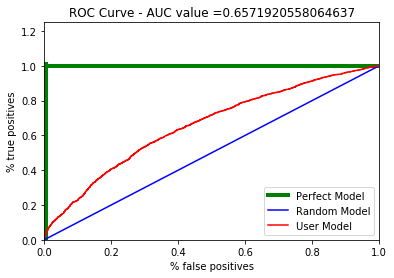

In [104]:
from sklearn.metrics import roc_curve, auc


y_preds_proba = rfc.predict_proba(X=X_testrf)
fpr, tpr, thresholds = roc_curve(y_testrf, y_preds_proba[:,1], pos_label='A')
xx = np.arange(101) / float(100)
rfc_auc = auc(fpr,tpr)

plt.xlim(0, 1.0)
plt.ylim(0, 1.25)
plt.plot([0.0, 0.0], [0.0, 1.0], color='green', linewidth=8)
plt.plot([0.0, 1.0], [1.0, 1.0], color='green', label='Perfect Model', linewidth=4)
plt.plot(xx,xx, color='blue', label='Random Model')
plt.plot(fpr,tpr, color='red', label='User Model')
plt.title("ROC Curve - AUC value ="+str(rfc_auc))
plt.xlabel('% false positives')
plt.ylabel('% true positives')
plt.legend()
plt.show()

With an AUC of 0.6646, it appears our model has some capacity for class separation but not an extraordinary amount. In particular, higher accuracy generates higher false positive values, something to keep in mind if this model is taken to production. Finally, let's plot our feature importances.

In [105]:
rfc2.score(X_testrf2, y_testrf2)

0.5753653444676409

Much less accurate model at 57.537% accuracy. Again, this is not the complete picture - the ROC curve and AUC score will indicate if there is a precision tradeoff.

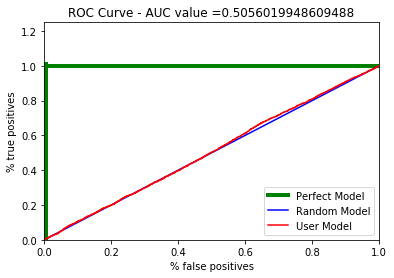

In [106]:
y_preds_proba2 = rfc2.predict_proba(X=X_testrf2)
fpr2, tpr2, thresholds = roc_curve(y_testrf2, y_preds_proba2[:,1], pos_label=True)
xx = np.arange(101) / float(100)
rfc_auc2 = auc(fpr2,tpr2)

plt.xlim(0, 1.0)
plt.ylim(0, 1.25)
plt.plot([0.0, 0.0], [0.0, 1.0], color='green', linewidth=8)
plt.plot([0.0, 1.0], [1.0, 1.0], color='green', label='Perfect Model', linewidth=4)
plt.plot(xx,xx, color='blue', label='Random Model')
plt.plot(fpr2,tpr2, color='red', label='User Model')
plt.title("ROC Curve - AUC value ="+str(rfc_auc2))
plt.xlabel('% false positives')
plt.ylabel('% true positives')
plt.legend()
plt.show()

With an AUC score very close to .5, this model has almost no capacity to distinguish positive classes. In other words, this random forest method behaves similar to a random state, and generates nearly as many false positives as true positives. Some insights into feature importance could indicate the reason for this. 

## KNN

In [107]:
# Task 1: Grade grouping
knn_scores_list = list(zip(grid_knn.cv_results_['params'], grid_knn.cv_results_['mean_test_score'],
                          grid_knn.cv_results_['std_test_score'], grid_knn.cv_results_['rank_test_score'])) 

knn_scores_pd = pd.DataFrame(knn_scores_list, columns = ['Parameter Set', 'Mean Test Score',
                                                        'STD Test Score', 'Rank'])
knn_scores_pd.sort_values(by=['Rank']).head(10)

,Parameter Set,Mean Test Score,STD Test Score,Rank
0,"{'algorithm': 'auto', 'n_neighbors': 1, 'weigh...",0.853064,0.002655,1
1,"{'algorithm': 'auto', 'n_neighbors': 1, 'weigh...",0.853064,0.002655,1
21,"{'algorithm': 'kd_tree', 'n_neighbors': 1, 'we...",0.853064,0.002655,1
20,"{'algorithm': 'kd_tree', 'n_neighbors': 1, 'we...",0.853064,0.002655,1
11,"{'algorithm': 'ball_tree', 'n_neighbors': 1, '...",0.853064,0.002655,1
10,"{'algorithm': 'ball_tree', 'n_neighbors': 1, '...",0.853064,0.002655,1
31,"{'algorithm': 'brute', 'n_neighbors': 1, 'weig...",0.853046,0.002668,7
30,"{'algorithm': 'brute', 'n_neighbors': 1, 'weig...",0.853046,0.002668,7
23,"{'algorithm': 'kd_tree', 'n_neighbors': 3, 'we...",0.850668,0.002248,9
33,"{'algorithm': 'brute', 'n_neighbors': 3, 'weig...",0.850668,0.002248,9


In [108]:
# Task 2: Superhost
knn_scores_super_list = list(zip(grid_knn_super.cv_results_['params'], grid_knn_super.cv_results_['mean_test_score'],
                          grid_knn_super.cv_results_['std_test_score'], grid_knn_super.cv_results_['rank_test_score'])) 

knn_scores_super_pd = pd.DataFrame(knn_scores_super_list, columns = ['Parameter Set', 'Mean Test Score',
                                                        'STD Test Score', 'Rank'])
knn_scores_super_pd.sort_values(by=['Rank']).head(10)

,Parameter Set,Mean Test Score,STD Test Score,Rank
23,"{'algorithm': 'kd_tree', 'n_neighbors': 3, 'we...",0.431503,0.006819,1
13,"{'algorithm': 'ball_tree', 'n_neighbors': 3, '...",0.431503,0.006819,1
3,"{'algorithm': 'auto', 'n_neighbors': 3, 'weigh...",0.431503,0.006819,1
33,"{'algorithm': 'brute', 'n_neighbors': 3, 'weig...",0.431448,0.006825,4
12,"{'algorithm': 'ball_tree', 'n_neighbors': 3, '...",0.430571,0.007790,5
2,"{'algorithm': 'auto', 'n_neighbors': 3, 'weigh...",0.430571,0.007790,5
22,"{'algorithm': 'kd_tree', 'n_neighbors': 3, 'we...",0.430571,0.007790,5
32,"{'algorithm': 'brute', 'n_neighbors': 3, 'weig...",0.430516,0.007802,8
36,"{'algorithm': 'brute', 'n_neighbors': 7, 'weig...",0.430348,0.008684,9
16,"{'algorithm': 'ball_tree', 'n_neighbors': 7, '...",0.430321,0.008643,10


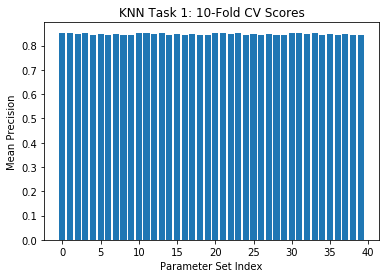

In [109]:
plt.bar(range(len(grid_knn.cv_results_['params'])), grid_knn.cv_results_['mean_test_score'])
plt.title('KNN Task 1: 10-Fold CV Scores')
plt.xlabel('Parameter Set Index')
plt.ylabel('Mean Precision')
plt.show()

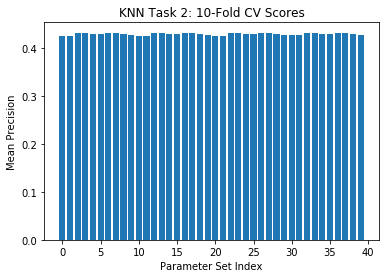

In [110]:
plt.bar(range(len(grid_knn_super.cv_results_['params'])), grid_knn_super.cv_results_['mean_test_score'])
plt.title('KNN Task 2: 10-Fold CV Scores')
plt.xlabel('Parameter Set Index')
plt.ylabel('Mean Precision')
plt.show()

GridSearch for KNN resulted in a best mean precision of 0.85318 for Task 1 and 0.431041 for Task 2. Despite the graphs above having similar shapes, the y-axis ranges reveal that KNN performed rather poorly on Task 2 for some reason. It's notable that the bar heights within each chart are relatively similar. Tuning the parameters within each model by changing things such as the algorithm or value of K resulted in very minor increases of predictive power on the test folds. 

In lieu of a scree plot on K alone, the top rows in the GridSearch tables tell the story that, even with other parameters in the sets changing, certain values of K seemed to be most optimal for each task. In particular, all eight sets using K=1 swept the highest mean precision scores for Task 1, meaning that those models only considered the closest neighbor to make a classification decision. Meanwhile, Task 2 had its highest mean precision scores with K=3.

***

# Modeling and Evaluation 5

<i><b>10 pts.</b> Discuss the advantages of each model for each classification task, if any. If there are not advantages, explain why. Is any model better than another? Is the difference significant with 95% confidence? Use proper statistical comparison methods. You must use statistical comparison techniques—be sure they are appropriate for your chosen method of validation as discussed in unit 7 of the course.</i>

Most advantages and disadvantages of the random forest model are the same as found in this method in general - it could easily be re-trained on any sample. If we were to localize the sample to a different city or type of listing this model would translate well; however, the accuracy and precision would be about the same regardless of the data. As we saw, the precision was not great, especially on task 2 (close to random state with AUC of ~.5). So while this method would be computationally efficient and easy to scale, it would also generate very imprecise responses, especially where superhosts are concerned.

<font color='red'>Logistic Regression has the advantage of giving coefficients, which can be interpretted as log odds and also give probabilities for a certain combination of variables. However, even though all our coefficients were significant in the logistic regression model, our overall model did a terrible job of predicting the below A class due to the class imbalance. </font>

For KNN, predictive performance for the grade classification task was approximately on par with logistic regression; the best mean precision on a 10-fold cross-validation given the grid of available parameters was 0.85317. However, performance on the superhost classification task was distinctly worse, with the best mean precision being only 0.43104.

Mean accuracy of Random Forest for task 1 is  0.8346024541652115
Mean accuracy of Logistic Regression for task 1 is  0.8338531734553796
Mean accuracy of KNN for task 1 is  0.8192510681646945


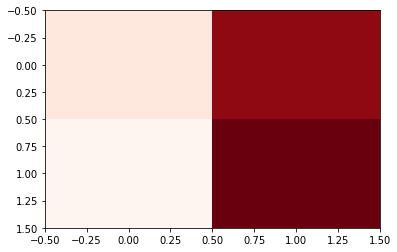

In [112]:
#task 1
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

cv=StratifiedKFold(n_splits=10)
models_and_accuracy = []
acc1 = cross_val_score(rfc, X1, y=y1, cv=cv)
acc2 = cross_val_score(lr_clf, X1, y=y1, cv=cv)
acc3 = cross_val_score(clf, X1, y=y1, cv=cv)

#=================================

print ('Mean accuracy of Random Forest for task 1 is ',np.mean(acc1))
print ('Mean accuracy of Logistic Regression for task 1 is ',np.mean(acc2))
print ('Mean accuracy of KNN for task 1 is ',np.mean(acc3))

#===============================
cm = confusion_matrix(y1, yhat1)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.imshow(cm_normalized,cmap=plt.get_cmap('Reds'),aspect='auto')
plt.grid(False)

In [135]:
#Confidence intervals for task 1

t = 2.26 / np.sqrt(10)

e1 = (1-acc1)-(1-acc2)
e2 = (1-acc2)-(1-acc3)
e3 = (1-acc1)-(1-acc3)

stdtot1 = np.std(e1)
stdtot2 = np.std(e2)
stdtot3 = np.std(e3)

# dbar = np.mean(e)
print ('CI for Random Forest/Logistic Regression Comparison, Task 1:', e1-t*stdtot1,e1+t*stdtot1 )
print ('CI for Logistic Regression/KNN Comparison, Task 1:', e2-t*stdtot2,e2+t*stdtot2 )
print ('CI for Random Forest/KNN Comparison, Task 1:', e3-t*stdtot3,e3+t*stdtot3)

CI for Random Forest/Logistic Regression Comparison, Task 1: [-2.99672307e-05 -4.47503765e-04 -4.47503765e-04 -2.38735498e-04
 -2.99672307e-05 -1.07380857e-03 -2.38735498e-04 -4.47503765e-04
  1.78888223e-04 -2.98800259e-05] [ 4.47503765e-04  2.99672307e-05  2.99672307e-05  2.38735498e-04
  4.47503765e-04 -5.96337571e-04  2.38735498e-04  2.99672307e-05
  6.56359219e-04  4.47590970e-04]
CI for Logistic Regression/KNN Comparison, Task 1: [-0.05113357 -0.05677031 -0.06031937 -0.05113357 -0.05906676 -0.04382668
 -0.05530893 -0.0594843  -0.04968183 -0.05303315] [-0.04406476 -0.0497015  -0.05325056 -0.04406476 -0.05199796 -0.03675787
 -0.04824013 -0.05241549 -0.04261302 -0.04596434]
CI for Random Forest/KNN Comparison, Task 1: [-0.05087622 -0.0569305  -0.06047956 -0.05108498 -0.05880941 -0.04461317
 -0.05526035 -0.05964448 -0.04921562 -0.05277571] [-0.04390458 -0.04995886 -0.05350792 -0.04411335 -0.05183777 -0.03764153
 -0.04828871 -0.05267284 -0.04224398 -0.04580407]


As we had mentioned before, we are using 10 fold stratified cross validation on these models to account for the imbalanced classifications. With accuracies between 81 and 83% for each model, it would appear that each of these models performs similarly across each fold. Confidence intervals confirm this, which each comparison being very narrow and containing 0.

Mean accuracy of Random Forest for task 2 is  0.5753596256853133
Mean accuracy of Logistic Regression for task 2 is  0.5753178894710056
Mean accuracy of KNN for task 2 is  0.5248764459445985


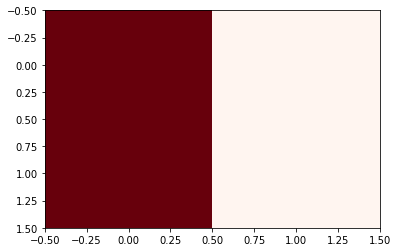

In [116]:
lr_clf = LogisticRegression(penalty='l2', C=1.0, class_weight=None, solver='liblinear' ) 
lr_clf.fit(X_train, y_train)
#confidence intervals for task 2
cv=StratifiedKFold(n_splits=10)
acc1 = cross_val_score(rfc2, X2, y=y2, cv=cv)
acc2 = cross_val_score(lr_clf, X2, y=y2, cv=cv)
acc3 = cross_val_score(knn, X2, y=y2, cv=cv)

#=================================

print ('Mean accuracy of Random Forest for task 2 is ',np.mean(acc1))
print ('Mean accuracy of Logistic Regression for task 2 is ',np.mean(acc2))
print ('Mean accuracy of KNN for task 2 is ',np.mean(acc3))

#===============================
cm = confusion_matrix(y2, yhat2)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.imshow(cm_normalized,cmap=plt.get_cmap('Reds'),aspect='auto')
plt.grid(False)

In [134]:
t = 2.26 / np.sqrt(10)

e1 = (1-acc1)-(1-acc2)
e2 = (1-acc2)-(1-acc3)
e3 = (1-acc1)-(1-acc3)

stdtot1 = np.std(e1)
stdtot2 = np.std(e2)
stdtot3 = np.std(e3)

# dbar = np.mean(e)
print ('CI for Random Forest/Logistic Regression Comparison, Task 2:', e1-t*stdtot1,e1+t*stdtot1 )
print ('CI for Logistic Regression/KNN Comparison, Task 2:', e2-t*stdtot2,e2+t*stdtot2 )
print ('CI for Random Forest/KNN Comparison, Task 2:', e3-t*stdtot3,e3+t*stdtot3)

CI for Random Forest/Logistic Regression Comparison, Task 2: [-2.99672307e-05 -4.47503765e-04 -4.47503765e-04 -2.38735498e-04
 -2.99672307e-05 -1.07380857e-03 -2.38735498e-04 -4.47503765e-04
  1.78888223e-04 -2.98800259e-05] [ 4.47503765e-04  2.99672307e-05  2.99672307e-05  2.38735498e-04
  4.47503765e-04 -5.96337571e-04  2.38735498e-04  2.99672307e-05
  6.56359219e-04  4.47590970e-04]
CI for Logistic Regression/KNN Comparison, Task 2: [-0.05113357 -0.05677031 -0.06031937 -0.05113357 -0.05906676 -0.04382668
 -0.05530893 -0.0594843  -0.04968183 -0.05303315] [-0.04406476 -0.0497015  -0.05325056 -0.04406476 -0.05199796 -0.03675787
 -0.04824013 -0.05241549 -0.04261302 -0.04596434]
CI for Random Forest/KNN Comparison, Task 2: [-0.05087622 -0.0569305  -0.06047956 -0.05108498 -0.05880941 -0.04461317
 -0.05526035 -0.05964448 -0.04921562 -0.05277571] [-0.04390458 -0.04995886 -0.05350792 -0.04411335 -0.05183777 -0.03764153
 -0.04828871 -0.05267284 -0.04224398 -0.04580407]


We see a similar case in task 2. While there appears to be a larger discrepancy in performance when comparing KNN to the rest of the models, it is not large enough to be statistically significant, as both CI's contain 0 when compared to the other two models.

***

# Modeling and Evaluation 6

<i><b>10 pts.</b> Which attributes from your analysis are most important? Use proper methods discussed in class to evaluate the importance of different attributes. Discuss the results and hypothesize about why certain attributes are more important than others for a given classification task.</i>

Feature ranking:
1. feature 6 (0.232093)
2. feature 12 (0.189276)
3. feature 11 (0.116710)
4. feature 0 (0.110756)
5. feature 7 (0.083437)
6. feature 14 (0.052620)
7. feature 8 (0.048413)
8. feature 24 (0.040697)
9. feature 26 (0.033344)
10. feature 20 (0.020878)
11. feature 13 (0.016026)
12. feature 5 (0.011226)
13. feature 1 (0.009463)
14. feature 18 (0.008711)
15. feature 27 (0.007706)
16. feature 10 (0.004844)
17. feature 35 (0.004298)
18. feature 25 (0.003184)
19. feature 2 (0.003104)
20. feature 3 (0.001826)
21. feature 28 (0.001387)
22. feature 19 (0.000000)
23. feature 30 (0.000000)
24. feature 33 (0.000000)
25. feature 4 (0.000000)
26. feature 32 (0.000000)
27. feature 31 (0.000000)
28. feature 9 (0.000000)
29. feature 29 (0.000000)
30. feature 34 (0.000000)
31. feature 23 (0.000000)
32. feature 22 (0.000000)
33. feature 21 (0.000000)
34. feature 15 (0.000000)
35. feature 16 (0.000000)
36. feature 17 (0.000000)


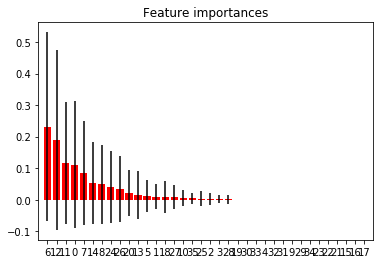

host_response_rate                     0.232093
length_amenities                       0.189276
price                                  0.116710
log_price                              0.110756
instant_bookable                       0.083437
TV                                     0.052620
number_of_reviews                      0.048413
city_NYC                               0.040697
cancellation_policy_moderate           0.033344
host_since_days                        0.020878
internet                               0.016026
host_identity_verified                 0.011226
accommodates                           0.009463
parking                                0.008711
cancellation_policy_strict             0.007706
beds                                   0.004844
room_type_Shared room                  0.004298
city_SF                                0.003184
bathrooms                              0.003104
cleaning_fee                           0.001826
cancellation_policy_super_strict_30    0

In [117]:
importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

print("Feature ranking:")

for f in range(X_testrf.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_testrf.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_testrf.shape[1]), indices)
plt.xlim([-1, X_testrf.shape[1]])
plt.show()

feature_df = df_final.drop(['grade_grouped'],axis=1)
important_features = pd.Series(data=rfc.feature_importances_,index=feature_df.columns)
important_features.sort_values(ascending=False,inplace=True)
print(important_features)

It appears that four of our features such as the description of amenities, responsiveness of the host, and of course the price, are informative of the model, while the rest are less so. Let's examine the other model. Task 2 involves subsetting the A grade and determining the probability a user will become a superuser (grade 96 or higher). We used the same type of model, so let's gather similar metrics.

Feature ranking:
1. feature 0 (0.128049)
2. feature 11 (0.121119)
3. feature 19 (0.110104)
4. feature 8 (0.095137)
5. feature 12 (0.094657)
6. feature 2 (0.062310)
7. feature 6 (0.055745)
8. feature 1 (0.051875)
9. feature 10 (0.050816)
10. feature 9 (0.048609)
11. feature 23 (0.016702)
12. feature 5 (0.014231)
13. feature 25 (0.014079)
14. feature 18 (0.013367)
15. feature 27 (0.012039)
16. feature 33 (0.011788)
17. feature 24 (0.010266)
18. feature 34 (0.010191)
19. feature 29 (0.009780)
20. feature 13 (0.009104)
21. feature 4 (0.008601)
22. feature 15 (0.007952)
23. feature 26 (0.007130)
24. feature 21 (0.006813)
25. feature 3 (0.006599)
26. feature 28 (0.004571)
27. feature 14 (0.004350)
28. feature 22 (0.003552)
29. feature 7 (0.003518)
30. feature 31 (0.003257)
31. feature 30 (0.002843)
32. feature 32 (0.000847)
33. feature 16 (0.000000)
34. feature 20 (0.000000)
35. feature 17 (0.000000)


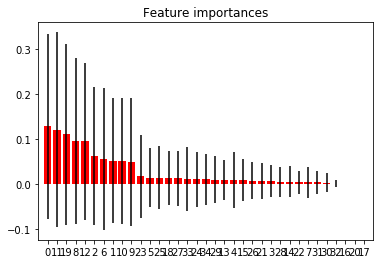

log_price                              0.128049
price                                  0.121119
host_since_days                        0.110104
number_of_reviews                      0.095137
length_amenities                       0.094657
bathrooms                              0.062310
host_response_rate                     0.055745
accommodates                           0.051875
beds                                   0.050816
bedrooms                               0.048609
city_NYC                               0.016702
host_identity_verified                 0.014231
cancellation_policy_moderate           0.014079
parking                                0.013367
cancellation_policy_super_strict_30    0.012039
room_type_Private room                 0.011788
city_SF                                0.010266
room_type_Shared room                  0.010191
bed_type_Couch                         0.009780
internet                               0.009104
host_has_profile_pic                   0

In [118]:
importances = rfc2.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc2.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

print("Feature ranking:")

for f in range(X_testrf2.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_testrf2.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_testrf2.shape[1]), indices)
plt.xlim([-1, X_testrf2.shape[1]])
plt.show()

feature_df = df_final.drop(['superuser','grade_grouped'],axis=1)
important_features = pd.Series(data=rfc2.feature_importances_,index=feature_df.columns)
important_features.sort_values(ascending=False,inplace=True)
print(important_features)

Feature 0, confirmed to be log_price has considerable leverage, with several features such as bathrooms and number of accommodations, as well as the hosts length of activity and number of reviews having roughly even importances. With this many features with roughly even mean accuracy decreases, it's hard to say if any one feature could influence the model. Given all this information, using random forest to predict superuser status may not be feasible.

In [ ]:
#feature importance from RF, iterate/optimize K neighbors, f test on regression

<font color='red'>Logistic regression does not have explicit feature importance. A feature is considered importnat if its coefficient is significant in the logistic regression model.</font>

A downside to KNN is that the algorithm does not directly provide a way to determine feature importance. When considering distances in multidimensional space, one would need to somehow calculate which attributes have the strongest influence in similarly classified data points being located near each other. The number of neighbors to consider is very important in this regard, and using GridSearch helped identify optimal k to eke out increased predictive power. The grade task ended up with multiple optimally performing parameter sets, but their shared feature was that they all used K = 1. The superhost task, which KNN performed poorly on, landed on K = 3.

In [ ]:
# Hold space for code

***

# Deployment

<i><b>5 pts.</b> How useful is your model for interested parties (i.e., the companies or organizations that might want to use it for prediction)? How would you measure the model's value if it was used by these parties? How would you deploy your model for interested parties? What other data should be collected? How often would the model need to be updated, etc.?</i>

In [ ]:
#clarify in class, explaining profit to shareholders (superhosts provide more to Airbnb than regular hosts, we can identify users that meet those requirements and can actively recruit for the program)

The main beneficiary for this classification exercise (particularly for the stricter superhost category, as opposed to the bucketed A grade) would likely be Airbnb itself. With their track record for exemplary service, superhosts are trusted hosts who are likely to provide guests with a great experience, thus maintaining 

Assuming that feature importance can parse out specifics, if Airbnb shared which attributes are likely predictors for superhosts (aside from those already required to earn the designation, such as maintaining a high average rating and response rate), this could also benefit hosts striving for that status by suggesting what could be improved to increase the likelihood of receiving good reviews. Potential guests would likely include superhost itself as a criterion in their search. If superhosts in their needed location are unavailable, perhaps knowing other strong predictors for a good experience, aside from rating, could give them better confidence in making a choice.

Specific feature importance revealed factors such as price, amenities, and host responsiveness to be key in a host's success on the platform. Airbnb could invest in a hosting toolkit for dedicated users, including things like determining price based on the features and amenities of the listing, and easier ways for hosts and guests to communicate. If these result in higher trustworthiness, and by extension revenue for the hosts and the company, this could be a strong return on investment for these models.

Only six particular US cities are considered in the original data. Training data from other cities, or potentially even for other countries in which Airbnb operates, should be implemented before generalizing any predictions outside of these six cities. Since the main superhost component affected by guest input is average rating, sentiment or keyword analysis on review text itself could be useful at indicating what hosts are doing right or wrong, giving them additional opportunity to improve in order to attain superhost status or avoid losing it.

Given the nature of this data, the model would likely need infrequent updates after being attuned. What constitutes a good guest experience is unlikely to change over time. The main deployment cost would likely be upfront, both with cleaning and implementing data for new locations Airbnb wants to predict on, as well as training the models. Tuning the model parameters is important for increasing predictive power, but it comes at a high potential computational cost. For instance, using GridSearch to find the optimal parameter set can take hours.

***

# Exceptional Work

<i><b>10 pts.</b> You have free reign to provide additional analyses. One idea: grid search parameters in a parallelized fashion and visualize the performances across attributes. Which parameters are most significant for making a good model for each classification algorithm?</i>

From the work in the regular sections outlined above, we'd like to propose the following items for consideration as exceptional work:

* Using GridSearch for KNN parameter tuning.

In addition, some experimentation with models not explicitly covered by class materials is shown below. Unless stated, these are done for the grouped grade task (using X1 and y1) only.

## XGBoost

In [119]:
from xgboost import XGBClassifier

In [120]:


xgb_precisions = []

# XGBoost on 10-fold CV
for train, test in cv.split(X1,y1):
    clf_xgb = XGBClassifier()
    clf_xgb.fit(X1[train],y1[train])
    yhat1[test] = clf_xgb.predict(X1[test])
    xgb_precisions.append(precision_score(y1[test], yhat1[test]))
    print(classification_report(y1[test], yhat1[test]))

              precision    recall  f1-score   support

       False       0.57      0.03      0.05       950
        True       0.84      1.00      0.91      4790

    accuracy                           0.84      5740
   macro avg       0.70      0.51      0.48      5740
weighted avg       0.79      0.84      0.77      5740

              precision    recall  f1-score   support

       False       0.68      0.03      0.05       950
        True       0.84      1.00      0.91      4790

    accuracy                           0.84      5740
   macro avg       0.76      0.51      0.48      5740
weighted avg       0.81      0.84      0.77      5740

              precision    recall  f1-score   support

       False       0.63      0.02      0.03       949
        True       0.84      1.00      0.91      4790

    accuracy                           0.84      5739
   macro avg       0.73      0.51      0.47      5739
weighted avg       0.80      0.84      0.77      5739

              preci

In [121]:
xgb_precisions_np = np.asarray(xgb_precisions)
xgb_precisions_np.mean()

0.8373212496238891

Using a similar stratified K-fold cross validator as shown above, an untuned XGBoost model returned comparable average precision. 

Shown below is a graph of relative feature importance, which indicates that features with indices 11, 7, and 6 seemed to be the top three most important. These correspond to amenities length, being instant bookable, and host response rate, respectively. Considering that having a high grade (related to this classification task, A or <A) is a prerequisite for the superhost designation, it's not surprising that response rate, another prerequisite, also gets included. For number one, the length of the amenities a site has, this makes sense as well. Having available features useful to guests, such as Wi-Fi, air conditioning, or laundry, increases the likelihood that guests will have good experiences and will then leave good reviews.

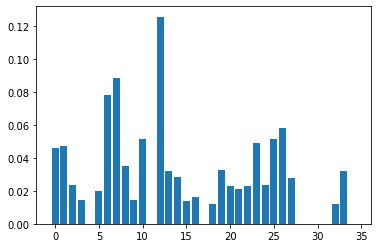

In [122]:
plt.bar(range(len(clf_xgb.feature_importances_)), clf_xgb.feature_importances_)
plt.show()

## Neural Networks

In [123]:
from sklearn.model_selection import KFold
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier

In [124]:

percep_precisions = []
kf = KFold(n_splits=10)

for train, test in kf.split(X1):
    clf_per = Perceptron(tol=1e-3, random_state=0)
    clf_per.fit(X1[train], y1[train])
    yhat1[test] = clf_per.predict(X1[test])
    percep_precisions.append(precision_score(y1[test], yhat1[test]))
    print(classification_report(y1[test], yhat1[test]))

              precision    recall  f1-score   support

       False       0.20      0.37      0.26       951
        True       0.85      0.70      0.77      4788

    accuracy                           0.65      5739
   macro avg       0.52      0.54      0.51      5739
weighted avg       0.74      0.65      0.68      5739

              precision    recall  f1-score   support

       False       0.22      0.27      0.24       955
        True       0.85      0.81      0.83      4784

    accuracy                           0.72      5739
   macro avg       0.53      0.54      0.53      5739
weighted avg       0.74      0.72      0.73      5739

              precision    recall  f1-score   support

       False       0.28      0.17      0.21       932
        True       0.85      0.92      0.88      4807

    accuracy                           0.79      5739
   macro avg       0.56      0.54      0.54      5739
weighted avg       0.76      0.79      0.77      5739

              preci

In [125]:
percep_precisions_np = np.asarray(percep_precisions)
percep_precisions_np.mean()

0.8446571709982162

Using a similar stratified K-fold cross validator as those implemented in the main section, a single-layer perceptron without much tuning was able to post a comparable mean precision score with a blisteringly fast time.

In [126]:

# Backpropagation neural network
# Code adapted from https://stackoverflow.com/questions/44683197/implement-k-fold-cross-validation-in-mlpclassification-python
bpnn_precisions = []

clf_mlp = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5,5,2),
                   random_state=1)
for train, test in kf.split(X1):
    clf_mlp.fit(X1[train], y1[train])
    yhat1[test] = clf_mlp.predict(X1[test])
    bpnn_precisions.append(precision_score(y1[test], yhat1[test]))
    print(classification_report(y1[test], yhat1[test]))

              precision    recall  f1-score   support

       False       0.00      0.00      0.00       951
        True       0.83      1.00      0.91      4788

    accuracy                           0.83      5739
   macro avg       0.42      0.50      0.45      5739
weighted avg       0.70      0.83      0.76      5739

              precision    recall  f1-score   support

       False       0.59      0.04      0.08       955
        True       0.84      0.99      0.91      4784

    accuracy                           0.84      5739
   macro avg       0.72      0.52      0.50      5739
weighted avg       0.80      0.84      0.77      5739

              precision    recall  f1-score   support

       False       0.44      0.03      0.05       932
        True       0.84      0.99      0.91      4807

    accuracy                           0.84      5739
   macro avg       0.64      0.51      0.48      5739
weighted avg       0.78      0.84      0.77      5739

              preci

In [127]:
bpnn_precisions_np = np.asarray(bpnn_precisions)
bpnn_precisions_np.mean()

0.8378454208380063

An attempt at a neural network using an ordinary backpropagation learning algorithm returns a similar, though slightly lower average precision. This could likely be improved with dedicated parameter tuning.

## Naive Bayes

In [128]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

In [129]:
clf_gnb = GaussianNB()
clf_mnb = MultinomialNB(alpha=0.001)
clf_bnb = BernoulliNB(alpha=0.001)

gnb_precisions = []
mnb_precisions = []
bnb_precisions = []

# GaussianNB
for train, test in kf.split(X1):
    clf_gnb.fit(X1[train], y1[train])
    yhat1[test] = clf_gnb.predict(X1[test])
    gnb_precisions.append(precision_score(y1[test], yhat1[test]))

# MultinomialNB results in error due to a negative value in X1?
# for train, test in kf.split(X1):
#     clf_mnb.fit(X1[train], y1[train])
#     yhat1[test] = clf_mnb.predict(X1[test])
#     mnb_precisions.append(precision_score(y1[test], yhat1[test]))

# BernoulliNB
for train, test in kf.split(X1):
    clf_bnb.fit(X1[train], y1[train])
    yhat1[test] = clf_bnb.predict(X1[test])
    bnb_precisions.append(precision_score(y1[test], yhat1[test]))

In [130]:
gnb_precisions_np = np.asarray(gnb_precisions)
gnb_precisions_np.mean()

0.8436432971912474

In [131]:
bnb_precisions_np = np.asarray(bnb_precisions)
bnb_precisions_np.mean()

0.8411019018587643

Gaussian Naive Bayes and Bernoulli Naive Bayes also produced similar mean precisions, at approximately 0.84.

# Appendix

## Categorical Variable Exploration

* City influences a property's probability of getting an A. For example, you are more likely to get an A in San Francisco and Chicago and less likely to get an A in New York and Boston
* Instant bookable properties were significantly more likely to not get an A. Maybe this is because they do not put as much effort into preparation
* Having an entire property to yourself gave you a better chance at getting an A rating, followed by having a private room, and then having a shared room significantly decreased your probabilities of getting an A
* Having a real bed weirdly seems to be associated with less likelihood of an A. Maybe this is because the expectations are higher
* People with the most strict cancellation policies had the lowest probabilities of getting an A. Maybe this is due to the fact that people can still leave reviews after they cancel and still pay a deposit, or maybe it shows that the host was too strict in other areas 
* Having a cleaning fee is weirdly associated with an increased probability of getting an A. Maybe guests do not like cleaning up after themselves
* Having a profile pic and having your identity verified increases your probability of getting an A
* Based on EDA we can see that the following amenities make a property more likely to get an A:
    * having parking
    * having a pool
    * having a kitchen
    * having air conditioning
    * having a TV 
    * having internet 

In [ ]:
sns.countplot(data=df_logistic, x='grade_grouped')

(ggplot(df_logistic, aes('parking', fill='grade_grouped'))
 + geom_bar( position='fill')
)

(ggplot(df_logistic, aes('pool', fill='grade_grouped'))
 + geom_bar( position='fill')
)

(ggplot(df_logistic, aes('kitchen', fill='grade_grouped'))
 + geom_bar( position='fill')
)

(ggplot(df_logistic, aes('air_conditioning', fill='grade_grouped'))
 + geom_bar( position='fill')
)

(ggplot(df_logistic, aes('TV', fill='grade_grouped'))
 + geom_bar( position='fill')
)

(ggplot(df_logistic, aes('internet', fill='grade_grouped'))
 + geom_bar( position='fill')
)

(ggplot(df_logistic, aes('instant_bookable', fill='grade_grouped'))
 + geom_bar( position='fill')
)

(ggplot(df_logistic, aes('room_type', fill='grade_grouped'))
 + geom_bar( position='fill')
)

(ggplot(df_logistic, aes('bed_type', fill='grade_grouped'))
 + geom_bar( position='fill')
)

(ggplot(df_logistic, aes('cleaning_fee', fill='grade_grouped'))
 + geom_bar( position='fill')
)

(ggplot(df_logistic, aes('host_has_profile_pic', fill='grade_grouped'))
 + geom_bar( position='fill')
)

(ggplot(df_logistic, aes('host_identity_verified', fill='grade_grouped'))
 + geom_bar( position='fill')
)

(ggplot(df_logistic, aes('cancellation_policy', fill='grade_grouped'))
 + geom_bar( position='fill')
)

# Numerical Variable Exploration
* The following variables were associated with higher probabilities of getting an A:
    * being a host for longer
    * having longer descriptions
    * having more amenities
* The size of the property does not seem to really influence the probability of getting an A. We can see this because there are similar distributions for price, number beds, number bedrooms, number of bathrooms, and number of people the place can accomodate
* Surprisingly, the number of reviews and the host response rate do not seem to influence the probability of getting an A

In [ ]:
sns.boxplot(x='grade_grouped', y='host_since_days', data=df_logistic)

sns.boxplot(x='grade_grouped', y='description_length', data=df_logistic)

sns.boxplot(x='grade_grouped', y='length_amenities', data=df_logistic)

sns.boxplot(x='grade_grouped', y='price', data=df_logistic)

sns.boxplot(x='grade_grouped', y='beds', data=df_logistic)

sns.boxplot(x='grade_grouped', y='bedrooms', data=df_logistic)

sns.boxplot(x='superuser', y='number_of_reviews', data=df_logistic)

sns.boxplot(x='superuser', y='host_response_rate', data=df_logistic)

sns.boxplot(x='grade_grouped', y='bathrooms', data=df_logistic)

sns.boxplot(x='grade_grouped', y='accommodates', data=df_logistic)

#stacked bar chart of percentages
(ggplot(df_logistic, aes('city', fill='grade_grouped'))
 + geom_bar( position='fill')
)

# Look at collinearity

In [60]:
numerics = ['int64', 'float64']
df_corr = df_logistic.select_dtypes(include=numerics)
df_corr.head()

,accommodates,bathrooms,host_response_rate,number_of_reviews,bedrooms,beds,price,length_amenities,description_length,host_since_days
0,3,1.0,0.924026,2,1,1,150.0,9,211,2179
1,7,1.0,1.000000,6,3,3,169.0,15,1000,268
2,5,1.0,1.000000,10,1,3,145.0,19,1000,505
3,2,1.0,1.000000,4,0,1,115.0,12,699,1109
4,2,1.0,1.000000,3,1,1,85.0,10,1000,280


In [61]:
df_corr.corr()

,accommodates,bathrooms,host_response_rate,number_of_reviews,bedrooms,beds,price,length_amenities,description_length,host_since_days
accommodates,1.000000,0.498232,0.047379,0.031000,0.720385,0.824703,0.579029,0.258958,0.116491,-0.018579
bathrooms,0.498232,1.000000,0.018456,-0.040912,0.574308,0.513076,0.490656,0.161037,0.044418,-0.006523
host_response_rate,0.047379,0.018456,1.000000,0.117379,0.027709,0.047577,0.001935,0.131337,0.099819,-0.019037
number_of_reviews,0.031000,-0.040912,0.117379,1.000000,-0.038597,0.022787,-0.044057,0.144332,0.227540,0.201491
bedrooms,0.720385,0.574308,0.027709,-0.038597,1.000000,0.704858,0.551253,0.182850,0.082153,0.015285
beds,0.824703,0.513076,0.047577,0.022787,0.704858,1.000000,0.491563,0.229713,0.092062,-0.031468
price,0.579029,0.490656,0.001935,-0.044057,0.551253,0.491563,1.000000,0.191038,0.062491,0.051808
length_amenities,0.258958,0.161037,0.131337,0.144332,0.182850,0.229713,0.191038,1.000000,0.269240,-0.038405
description_length,0.116491,0.044418,0.099819,0.227540,0.082153,0.092062,0.062491,0.269240,1.000000,0.185753
host_since_days,-0.018579,-0.006523,-0.019037,0.201491,0.015285,-0.031468,0.051808,-0.038405,0.185753,1.000000


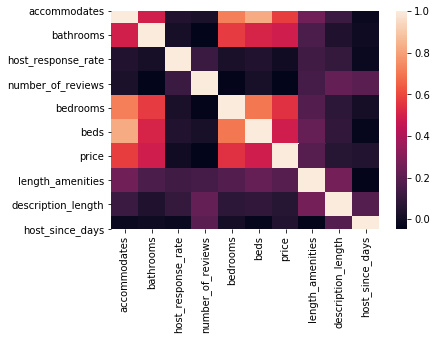

In [62]:
# no strong correlations between numerical variables
# rule of thumnb: correlation above 0.9 is problematic
sns.heatmap(df_corr.corr())
plt.show()

# Correlations between categorical variables and Numeric Variables
* will use ANOVA

In [63]:
import scipy.stats as stats

numerical_vars = list(df_logistic.select_dtypes(include=numerics).columns)
print(numerical_vars)

categorical_vars = list(df_logistic.select_dtypes(include=['category', 'bool']).columns)

print(categorical_vars)

['accommodates', 'bathrooms', 'host_response_rate', 'number_of_reviews', 'bedrooms', 'beds', 'price', 'length_amenities', 'description_length', 'host_since_days']
['room_type', 'bed_type', 'cancellation_policy', 'cleaning_fee', 'city', 'host_has_profile_pic', 'host_identity_verified', 'instant_bookable', 'grade', 'internet', 'TV', 'air_conditioning', 'kitchen', 'pool', 'parking', 'superuser']


#### Room type

In [64]:
#room_type is redundant
for var in numerical_vars:
    print(var, ': ')
    print(stats.f_oneway(df_logistic[var][df_logistic.room_type == 'Entire home/apt'], 
               df_logistic[var][df_logistic.room_type == 'Private room'],
               df_logistic[var][df_logistic.room_type == 'Shared room']))
    print()

accommodates : 
F_onewayResult(statistic=8311.260477381162, pvalue=0.0)

bathrooms : 
F_onewayResult(statistic=533.6824644984207, pvalue=2.2584378027609e-230)

host_response_rate : 
F_onewayResult(statistic=9.872934792213272, pvalue=5.163883408700995e-05)

number_of_reviews : 
F_onewayResult(statistic=25.88832682111481, pvalue=5.779784393585306e-12)

bedrooms : 
F_onewayResult(statistic=1791.7812374495722, pvalue=0.0)

beds : 
F_onewayResult(statistic=4317.176705064991, pvalue=0.0)

price : 
F_onewayResult(statistic=6820.273716593953, pvalue=0.0)

length_amenities : 
F_onewayResult(statistic=699.812004414434, pvalue=5.280719624892653e-301)

description_length : 
F_onewayResult(statistic=200.5409063304744, pvalue=1.6186136413727302e-87)

host_since_days : 
F_onewayResult(statistic=143.9161079301942, pvalue=4.51081762544199e-63)



#### Bed_type

In [65]:
for var in numerical_vars:
    print(var, ': ')
    print(stats.f_oneway(df_logistic[var][df_logistic.bed_type == 'Real Bed'], 
               df_logistic[var][df_logistic.bed_type == 'Futon'],
               df_logistic[var][df_logistic.bed_type == 'Pull-out Sofa'],
              df_logistic[var][df_logistic.bed_type == 'Couch'],
              df_logistic[var][df_logistic.bed_type == 'Airbed']))
    print()
    

accommodates : 
F_onewayResult(statistic=102.04947044326022, pvalue=9.630281590057128e-87)

bathrooms : 
F_onewayResult(statistic=27.904042696251405, pvalue=3.467200673340659e-23)

host_response_rate : 
F_onewayResult(statistic=2.353563913070348, pvalue=0.05155216075667624)

number_of_reviews : 
F_onewayResult(statistic=8.51600176921841, pvalue=7.262564854627648e-07)

bedrooms : 
F_onewayResult(statistic=60.372615039866616, pvalue=5.684462709636918e-51)

beds : 
F_onewayResult(statistic=74.1156356502596, pvalue=9.148265945184976e-63)

price : 
F_onewayResult(statistic=71.49261792865688, pvalue=1.6319097372406637e-60)

length_amenities : 
F_onewayResult(statistic=20.4191984055442, pvalue=7.901181515252077e-17)

description_length : 
F_onewayResult(statistic=10.248095157947763, pvalue=2.7155721454553722e-08)

host_since_days : 
F_onewayResult(statistic=14.19936597869075, pvalue=1.3822950226623125e-11)



#### Cancellation policy

In [66]:
for var in numerical_vars:
    print(var, ': ')
    print(stats.f_oneway(df_logistic[var][df_logistic.cancellation_policy == 'strict'], 
               df_logistic[var][df_logistic.cancellation_policy == 'moderate'],
               df_logistic[var][df_logistic.cancellation_policy == 'flexible'],
              df_logistic[var][df_logistic.cancellation_policy == 'super_strict_30'],
              df_logistic[var][df_logistic.cancellation_policy == 'super_strict_60']))
    print()
    

accommodates : 
F_onewayResult(statistic=625.362058848526, pvalue=0.0)

bathrooms : 
F_onewayResult(statistic=163.58453704084602, pvalue=1.688385471521771e-139)

host_response_rate : 
F_onewayResult(statistic=127.82475818932434, pvalue=7.413989514035901e-109)

number_of_reviews : 
F_onewayResult(statistic=388.6685401492283, pvalue=0.0)

bedrooms : 
F_onewayResult(statistic=303.0969869499843, pvalue=1.7788969602946338e-258)

beds : 
F_onewayResult(statistic=483.00142177331134, pvalue=0.0)

price : 
F_onewayResult(statistic=458.6254579107413, pvalue=0.0)

length_amenities : 
F_onewayResult(statistic=517.9927741542882, pvalue=0.0)

description_length : 
F_onewayResult(statistic=944.3057366911261, pvalue=0.0)

host_since_days : 
F_onewayResult(statistic=280.14155062709756, pvalue=5.731773057493463e-239)



Anova seems to be overly sensitive to finding correlations. I will stop here

# Correlations between categorical variables
* Use Cramers V for correlation between categorical variables. It ranges from 0 (no association) to 1 (strong association)

In [67]:
import scipy.stats as ss

In [68]:
categorical_vars = ['room_type', 'bed_type', 'cancellation_policy', 'cleaning_fee', 'city', 'host_has_profile_pic',
                   'host_identity_verified', 'instant_bookable', 'internet', 'TV', 'air_conditioning',
                   'kitchen', 'pool', 'parking']

df_logistic_correlation = df_logistic[categorical_vars]

In [69]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [70]:
for var in categorical_vars:
    print('The association of {} with the following variables is'.format(var))
    for var2 in categorical_vars:
        confusion_matrix = pd.crosstab(df_logistic_correlation[var], df_logistic_correlation[var2]).as_matrix()
        print(var2, ': ', cramers_v(df_logistic[var], df_logistic[var2]))
    print()

The association of room_type with the following variables is
room_type :  1.0
bed_type :  0.1793748065380461
cancellation_policy :  0.1220019589589836
cleaning_fee :  0.21826793323473284
city :  0.08172005270469712
host_has_profile_pic :  0.0
host_identity_verified :  0.05153835232246948
instant_bookable :  0.032603183603628745
internet :  0.05601238730062045
TV :  0.2599952029891558
air_conditioning :  0.08250167983345934
kitchen :  0.15153203675520513
pool :  0.05287497280484075
parking :  0.05222894743329889

The association of bed_type with the following variables is
room_type :  0.1793748065380461
bed_type :  1.0
cancellation_policy :  0.020333596740673206
cleaning_fee :  0.029661826563628393
city :  0.015766381325537843
host_has_profile_pic :  0.0
host_identity_verified :  0.012197281200082339
instant_bookable :  0.024833155023125213
internet :  0.023856576997351546
TV :  0.061251044773271084
air_conditioning :  0.037473028945249565
kitchen :  0.019682040308467517
pool :  0.01413

* Room type, bed type, cancellation policy, cleaning fee, having a profile pic, having your identity verified, being instant bookable,and having internet do not seem to have an any strong correlations with other variables
* City has moderate correlations with having parking, a pool, and air conditioning

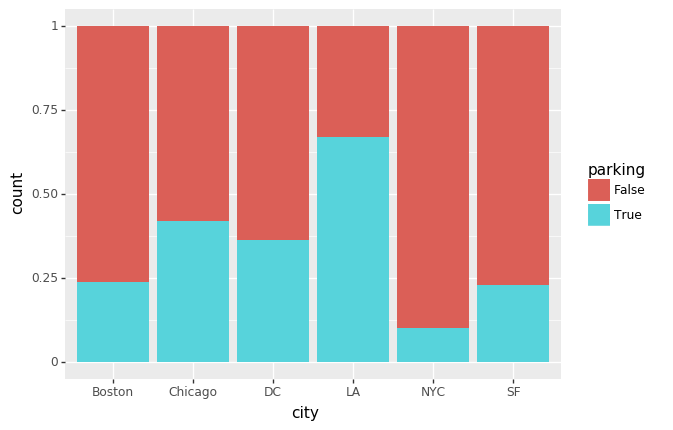

<ggplot: (7572398975)>

In [71]:
(ggplot(df_logistic, aes('city', fill='parking'))
 + geom_bar( position='fill')
)

Here we see that LA is the most likely to have parking, while NYC is the least likely to have parking

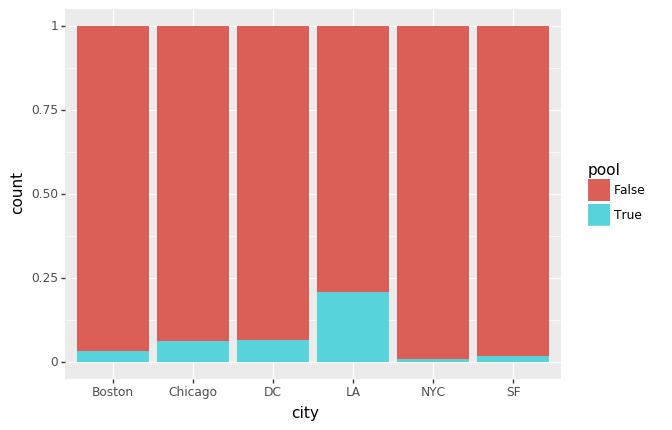

<ggplot: (-9223372029298036294)>

In [72]:
(ggplot(df_logistic, aes('city', fill='pool'))
 + geom_bar( position='fill')
)

Here we see that an LA property is the most likely to have a pool.

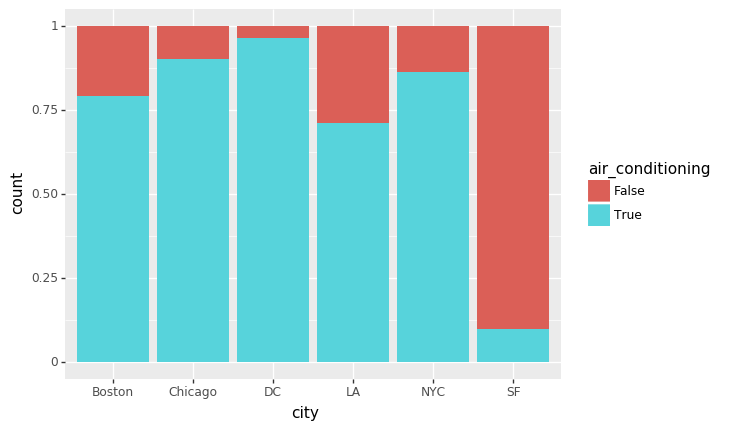

<ggplot: (7570176418)>

In [73]:
(ggplot(df_logistic, aes('city', fill='air_conditioning'))
 + geom_bar( position='fill')
)

Here we see that having AC is common in all the cities except San Francisco, where it is uncommon.